## Setting

In [11]:
import pandas as pd
import sys
import os
import numpy as np
from clust.pipeline import data_pipeline
from clust.tool import data_statistical, data_clustering
from clust.transformation.splitDataByCycle import dataByCycle
import datetime
from config import influxdb_client as db_client

sys.path.append("../")
sys.path.append("../..")
sys.path.append("../../..")
sys.path.append("../../../..")

## Get Data

In [13]:
bk_name = 'farm_protectedHorticulture_westernVegetables_paprika'
ms_name = 'environment_knu_n'
tags = {'FRM_ID': 'F00012', 'ZN_ID': '1구역'}
start_time = '2021-07-01 00:00:00'
end_time = '2021-10-31 23:59:59'
# end_time = '2021-11-01 00:00:00'

In [14]:
data = db_client.get_data_by_time(start_time, end_time, bk_name, ms_name, tags)
data

,EXT_TMP,EXT_WIND_DIRECT,EXT_WIND_SPEED,INT_CO2,INT_REL_HD,INT_TMP,MAX_EXT_TMP,MIN_EXT_TMP
time,,,,,,,,
2021-07-01 00:00:00+00:00,19.50,90.0,0.00,558.75,80.33,22.25,20.2,19.7
2021-07-01 00:10:00+00:00,19.87,90.0,0.30,394.20,63.42,13.31,20.3,19.5
2021-07-01 00:20:00+00:00,19.75,90.0,0.31,395.00,63.82,13.22,20.0,19.5
2021-07-01 00:30:00+00:00,19.69,90.0,0.15,399.50,63.63,13.21,19.8,19.5
2021-07-01 00:40:00+00:00,19.72,90.0,0.04,399.80,63.53,13.23,19.9,19.6
...,...,...,...,...,...,...,...,...
2021-10-31 19:00:00+00:00,9.24,NaN,0.31,447.76,90.44,16.09,NaN,NaN
2021-10-31 20:00:00+00:00,8.00,NaN,0.02,472.06,89.82,15.96,NaN,NaN
2021-10-31 21:00:00+00:00,7.22,NaN,0.00,497.28,90.00,16.31,NaN,NaN


## Data Slicing

In [15]:
cycle_unit = 'day'
cycle_count = 1
cycle_data = dataByCycle.generate_cycle_dataset(data, cycle_unit, cycle_count)

In [16]:
if len(data.columns) == 1:
    data_col = str(data.columns)

## Select Feature

In [17]:
selected_feature = "INT_CO2"
data = {key: df[[selected_feature]] for key, df in cycle_data.items() if selected_feature in df.columns }
data

{'2021-07-01 00:00:00+00:00 - 2021-07-01 23:50:00+00:00 | slice_1':                            INT_CO2
 time                              
 2021-07-01 00:00:00+00:00   558.75
 2021-07-01 00:10:00+00:00   394.20
 2021-07-01 00:20:00+00:00   395.00
 2021-07-01 00:30:00+00:00   399.50
 2021-07-01 00:40:00+00:00   399.80
 ...                            ...
 2021-07-01 23:10:00+00:00   428.80
 2021-07-01 23:20:00+00:00   418.30
 2021-07-01 23:30:00+00:00   424.60
 2021-07-01 23:40:00+00:00   425.00
 2021-07-01 23:50:00+00:00   425.80
 
 [144 rows x 1 columns],
 '2021-07-02 00:00:00+00:00 - 2021-07-02 23:50:00+00:00 | slice_2':                            INT_CO2
 time                              
 2021-07-02 00:00:00+00:00   526.75
 2021-07-02 00:10:00+00:00   432.10
 2021-07-02 00:20:00+00:00   434.50
 2021-07-02 00:30:00+00:00   440.60
 2021-07-02 00:40:00+00:00   436.80
 ...                            ...
 2021-07-02 23:10:00+00:00   360.10
 2021-07-02 23:20:00+00:00   361.80
 2021-07-02

## Define Helper Functions

In [18]:
def unify_data_timerange(data, freq=None, cycle_unit='day', cycle_count=1):
    """
    데이터의 시간 범위와 주기를 통일하는 함수
    
    Args:
        data (dict): 데이터셋 딕셔너리
        freq (timedelta): 사용할 주기 (None이면 자동 감지)
        cycle_unit (str): 사이클 단위 ('day', 'hour', 'minute')
        cycle_count (int): 사이클 개수
    
    Returns:
        dict: 통일된 데이터셋
    """
    print("=== 데이터 시간 범위 통일 처리 ===")
    
    # 주기 자동 감지
    if freq is None:
        min_freq = None
        for key, df in data.items():
            if len(df) > 1:
                detected_freq = df.index[1] - df.index[0]
                if min_freq is None or detected_freq < min_freq:
                    min_freq = detected_freq
        freq = min_freq
    
    print(f"사용할 주기: {freq}")
    
    # cycle_duration 동적 계산
    if cycle_unit == 'day':
        cycle_duration = pd.Timedelta(days=cycle_count)
    elif cycle_unit == 'hour':
        cycle_duration = pd.Timedelta(hours=cycle_count)
    elif cycle_unit == 'minute':
        cycle_duration = pd.Timedelta(minutes=cycle_count)
    else:
        raise ValueError(f"Unsupported cycle_unit: {cycle_unit}")
    
    unified_data = {}
    for key, df in data.items():
        print(f"[{key}] 원본 시간 범위: {df.index[0]} ~ {df.index[-1]} (길이: {len(df)})")
        
        # 시작 시간
        start_time = df.index[0]
        
        # 동적으로 종료 시간 계산 (하드코딩 제거)
        end_time = start_time + cycle_duration - freq
        
        complete_time_index = pd.date_range(start=start_time, end=end_time, freq=freq)
        
        # 재인덱싱만 수행 (보간은 pipeline에서)
        unified_df = df.reindex(complete_time_index)
        unified_data[key] = unified_df
        
        nan_count = unified_df.isna().sum().sum()
        print(f"[{key}] 통일 후: {unified_df.shape}, NaN: {nan_count}")
    
    return unified_data


def safe_plot_processing(plt1):
    """
    matplotlib plot의 안전한 처리 함수
    
    Args:
        plt1: matplotlib plot 객체
    
    Returns:
        str or None: base64 인코딩된 이미지 데이터
    """
    if plt1 is None:
        print("Warning: plt1 is None")
        return None
    
    try:
        # NaN/Inf 축 한계값 수정
        for ax in plt1.gcf().get_axes():
            xlim = ax.get_xlim()
            ylim = ax.get_ylim()
            
            if any(not np.isfinite(val) for val in xlim):
                ax.set_xlim(0, 1)
                print("Warning: Fixed invalid x-axis limits")
            
            if any(not np.isfinite(val) for val in ylim):
                ax.set_ylim(0, 1)
                print("Warning: Fixed invalid y-axis limits")
        
        # 이미지 생성
        from clust.tool.plot import plot_image
        figdata = plot_image.plt_to_image(plt1)
        plt1.close()  # 메모리 해제
        
        return figdata
        
    except Exception as e:
        print(f"Plot processing error: {e}")
        try:
            plt1.close()
        except:
            pass
        return None


def print_data_status(data, title):
    """
    데이터 상태 출력 함수
    
    Args:
        data (dict): 데이터셋
        title (str): 출력 제목
    """
    print(f"\n=== {title} ===")
    if isinstance(data, dict):
        for key, df in data.items():
            nan_count = df.isna().sum().sum()
            total_count = df.size
            print(f"[{key}] Shape: {df.shape}, NaN: {nan_count}/{total_count} ({nan_count/total_count*100:.1f}%)")

## Unify Data Timerange & Pipeline Processing

In [ ]:
# 파라미터 설정
freq = datetime.timedelta(seconds=600)

# 1. 데이터 시간 범위 통일 (NaN 생성)
data_unified = unify_data_timerange(data, freq, cycle_unit, cycle_count)


# 2. 파이프라인 처리 (보간, 스케일링)
pipeline_parameter = [
    ['data_refinement', 
     {'remove_duplication': {'flag': True}, 
      'static_frequency': {'flag': True, 'frequency': freq}}],
    ['data_imputation',
     {'flag': True,
      'imputation_method': [{'min': 0, 'max': 20000, 'method': 'linear', 'parameter': {}}],
      'total_non_NaN_ratio': 1}],
    ['data_scaling', {'flag': True, 'method': 'minmax'}]
]

processing_data = data_pipeline.pipeline(data_unified, pipeline_parameter)


=== 데이터 시간 범위 통일 처리 ===
사용할 주기: 0:10:00
[2021-07-01 00:00:00+00:00 - 2021-07-01 23:50:00+00:00 | slice_1] 원본 시간 범위: 2021-07-01 00:00:00+00:00 ~ 2021-07-01 23:50:00+00:00 (길이: 144)
[2021-07-01 00:00:00+00:00 - 2021-07-01 23:50:00+00:00 | slice_1] 통일 후: (144, 1), NaN: 0
[2021-07-02 00:00:00+00:00 - 2021-07-02 23:50:00+00:00 | slice_2] 원본 시간 범위: 2021-07-02 00:00:00+00:00 ~ 2021-07-02 23:50:00+00:00 (길이: 142)
[2021-07-02 00:00:00+00:00 - 2021-07-02 23:50:00+00:00 | slice_2] 통일 후: (144, 1), NaN: 2
[2021-07-03 00:00:00+00:00 - 2021-07-03 23:50:00+00:00 | slice_3] 원본 시간 범위: 2021-07-03 00:00:00+00:00 ~ 2021-07-03 23:50:00+00:00 (길이: 144)
[2021-07-03 00:00:00+00:00 - 2021-07-03 23:50:00+00:00 | slice_3] 통일 후: (144, 1), NaN: 0
[2021-07-04 00:00:00+00:00 - 2021-07-04 23:50:00+00:00 | slice_4] 원본 시간 범위: 2021-07-04 00:00:00+00:00 ~ 2021-07-04 23:50:00+00:00 (길이: 144)
[2021-07-04 00:00:00+00:00 - 2021-07-04 23:50:00+00:00 | slice_4] 통일 후: (144, 1), NaN: 0
[2021-07-05 00:00:00+00:00 - 2021-07-05 23:5

## Clustering & Visualization


=== 클러스터링 결과 ===
클러스터별 개수: {'Cluster 2': 23, 'Cluster 1': 66, 'Cluster 0': 32, 'Cluster 3': 1}
총 데이터 개수: [{'slice': '2021-07-01 00:00:00+00:00 - 2021-07-01 23:50:00+00:00 | slice_1', 'cluster': '2'}, {'slice': '2021-07-02 00:00:00+00:00 - 2021-07-02 23:50:00+00:00 | slice_2', 'cluster': '2'}, {'slice': '2021-07-03 00:00:00+00:00 - 2021-07-03 23:50:00+00:00 | slice_3', 'cluster': '2'}, {'slice': '2021-07-04 00:00:00+00:00 - 2021-07-04 23:50:00+00:00 | slice_4', 'cluster': '2'}, {'slice': '2021-07-05 00:00:00+00:00 - 2021-07-05 23:50:00+00:00 | slice_5', 'cluster': '2'}, {'slice': '2021-07-06 00:00:00+00:00 - 2021-07-06 23:50:00+00:00 | slice_6', 'cluster': '2'}, {'slice': '2021-07-07 00:00:00+00:00 - 2021-07-07 23:50:00+00:00 | slice_7', 'cluster': '2'}, {'slice': '2021-07-08 00:00:00+00:00 - 2021-07-08 23:50:00+00:00 | slice_8', 'cluster': '2'}, {'slice': '2021-07-09 00:00:00+00:00 - 2021-07-09 23:50:00+00:00 | slice_9', 'cluster': '1'}, {'slice': '2021-07-10 00:00:00+00:00 - 2021-07-

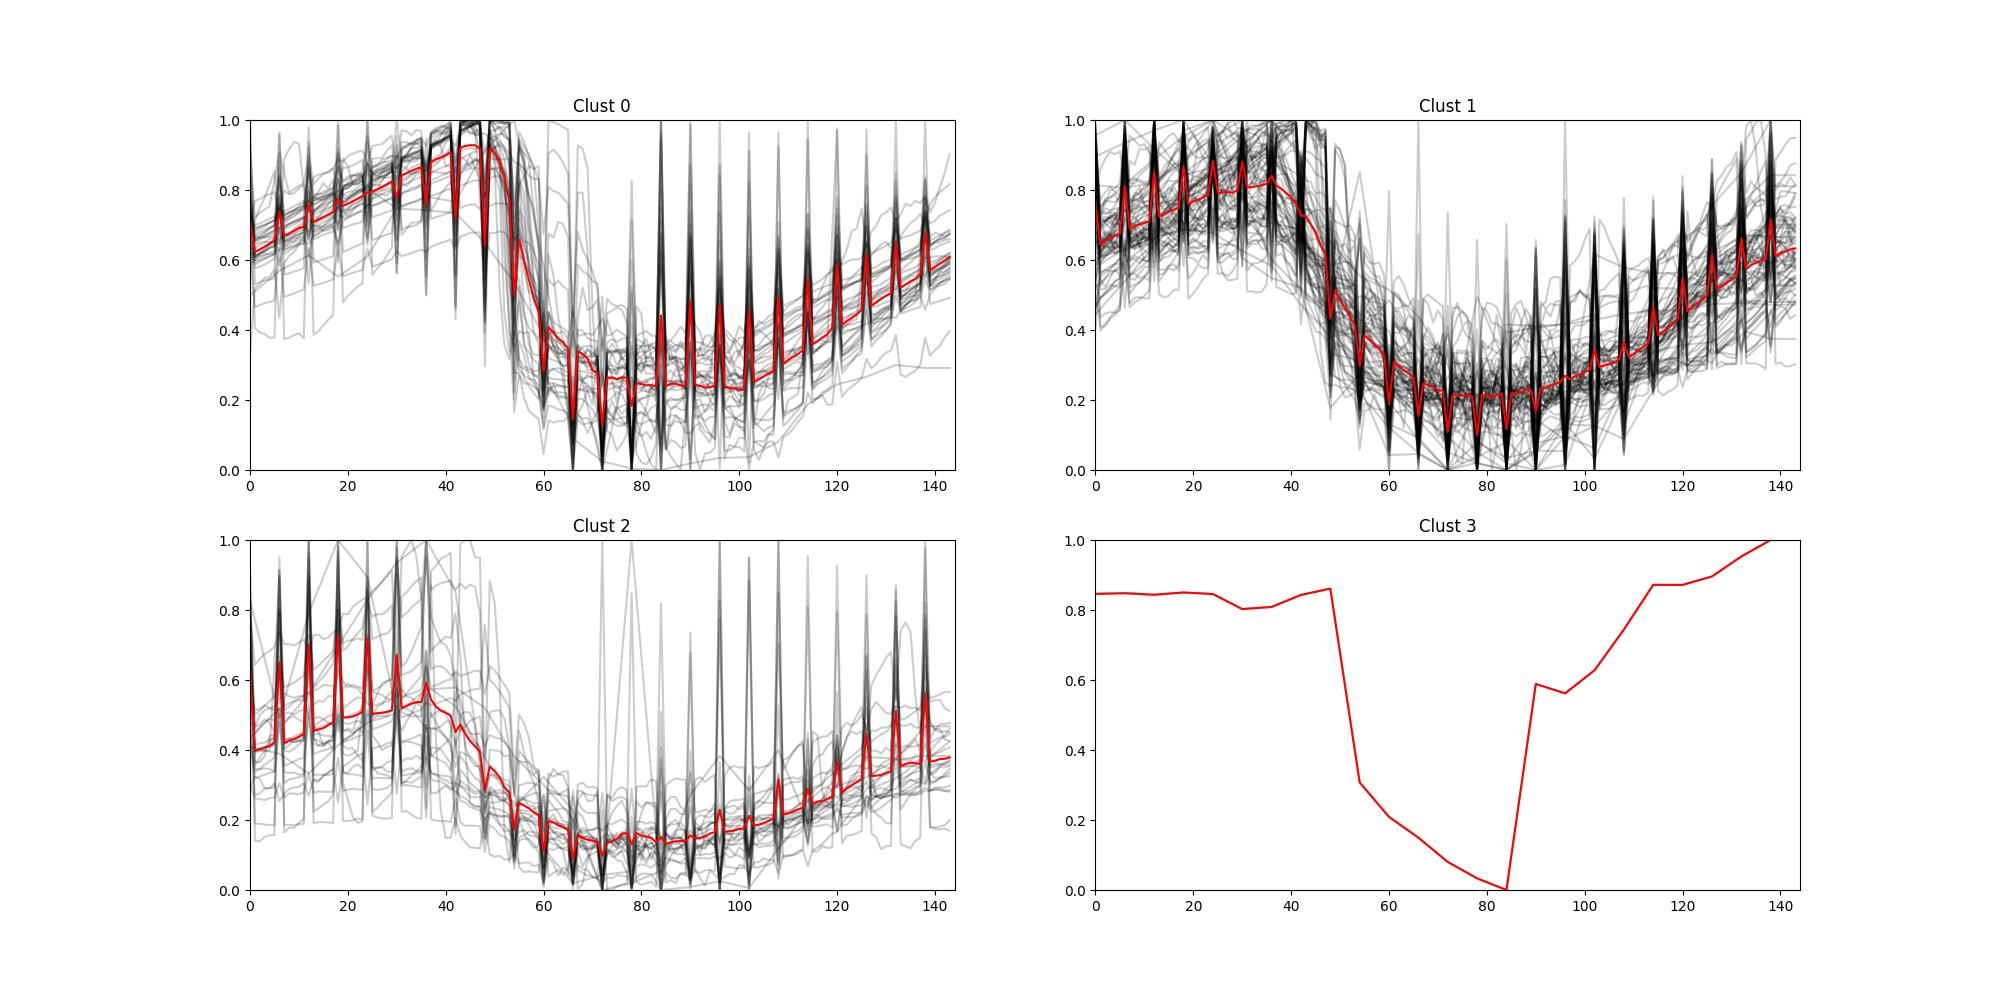

In [22]:
# 클러스터 개수 설정
cluster_num = 4

try:
    # 클러스터링 수행
    result, plt1 = data_clustering.data_clustering(processing_data, cluster_num, model_type='som')
    
    # 안전한 plot 처리
    figdata = safe_plot_processing(plt1)
    
    # 결과 생성
    from collections import Counter
    raw_counts = Counter(result.values())
    cluster_counts = {f"Cluster {label}": count for label, count in raw_counts.items()}
    result_table = [{"slice": key, "cluster": val} for key, val in result.items()]
    
    print("\n=== 클러스터링 결과 ===")
    print(f"클러스터별 개수: {cluster_counts}")
    print(f"총 데이터 개수: {result_table}")
    
    # 시각화 표시
    if figdata:
        from IPython.display import Image, display
        import base64
        display(Image(data=base64.b64decode(figdata)))
    
except Exception as e:
    import traceback
    error_details = traceback.format_exc()
    print(f"Clustering error: {error_details}")